

# **1.   Importing Necessary Libraries**



In [1]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
#Filepath of the data
filepath = '/content/cookie_cats.csv'

In [3]:
def load(filepath, info=True):
    """
    Loads a CSV or Excel file, displays data summary (shape, datatypes, missing values, and memory usage).

    :param filepath: str, Path to the file
    :param info: bool, If True, prints summary information
    :return: pandas DataFrame
    """

    # Load data based on file extension
    if filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filepath.endswith('.xlsx'):
        df = pd.read_excel(filepath)
    else:
        print("Error: Unsupported file format! This function only supports '.csv' and '.xlsx'.")
        return None

    # Handle empty data case
    if df.empty:
        print("Error: The file was loaded, but it contains no data.")
        return df

    # Print information if required
    if info:
        print("\n✅ Data imported successfully!")
        print("=" * 50)

        # Shape of the dataset
        print("\n📏 DIMENSIONS")
        print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.\n")

        # Data types summary
        print("🔢 DATA TYPES")
        print("=" * 50)

        dtype_categories = {
            "object": "Object Variables",
            "integer": "Integer Variables",
            "float": "Float Variables",
            "bool": "Boolean Variables"
        }

        for dtype, desc in dtype_categories.items():
            cols = df.select_dtypes(dtype).columns.tolist()
            if cols:
                print(f"\n📌 {desc} ({len(cols)} columns)\n{'-' * 20}")
                print(", ".join(cols), "\n")

        # Check for missing values
        print("\n🚨 MISSING VALUES")
        print("=" * 50)
        missing_values = df.isnull().sum().sum()
        if missing_values > 0:
            print(f"⚠️ The dataset contains {missing_values} missing values.")
        else:
            print("✅ No missing values detected!")

        # Memory usage
        print("\n🖥️ MEMORY USAGE")
        print("=" * 50)
        buf = io.StringIO()
        df.info(buf=buf)
        memory_usage = buf.getvalue().split("\n")[-2].split(":")[1].strip()
        print(f"💾 {memory_usage}\n")

    return df

# Example usage
df = load(filepath)  # Change the filename to match your actual file
df.head()


✅ Data imported successfully!

📏 DIMENSIONS
The dataset has 90189 rows and 5 columns.

🔢 DATA TYPES

📌 Object Variables (1 columns)
--------------------
version 


📌 Integer Variables (2 columns)
--------------------
userid, sum_gamerounds 


📌 Boolean Variables (2 columns)
--------------------
retention_1, retention_7 


🚨 MISSING VALUES
✅ No missing values detected!

🖥️ MEMORY USAGE
💾 2.2+ MB



,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# **2. Summary Statistics**

In [4]:
#Checking the number of unique users
if (df['userid'].nunique() == df.shape[0]):
    print("There are no dupliactes and all users are unique!")
else:
    print("There are duplicates in the data!!")

There are no dupliactes and all users are unique!


In [5]:
# Gives an overview of the distribution of sum_gamerounds, including extreme values.
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [6]:
# A/B Groups & Target Summary Stats
df.groupby('version')['sum_gamerounds'].agg(["min","count", "median", "mean", "std", "max"])

,min,count,median,mean,std,max
version,,,,,,
gate_30,0,44700,17.0000,52.4563,256.7164,49854
gate_40,0,45489,16.0000,51.2988,103.2944,2640


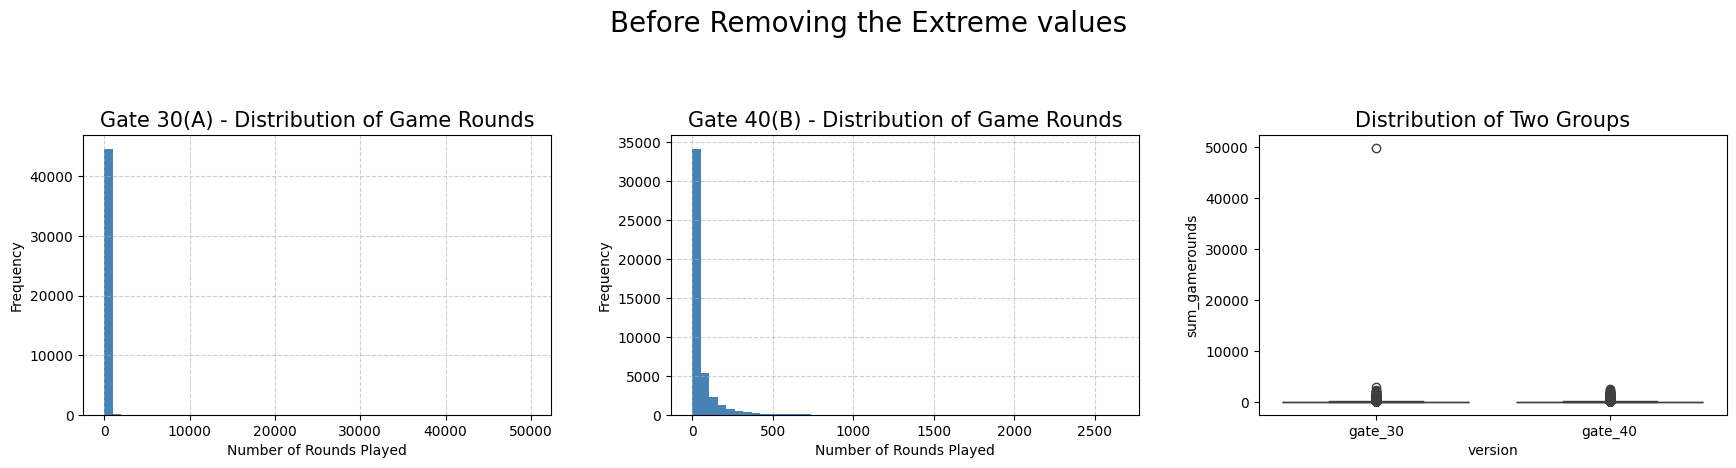

In [7]:
#Plotting the values to better understand the underlying distribution and to check the extreme values
fig,ax = plt.subplots(1,3,figsize=(18,5))
df[df['version'] == 'gate_30'].hist('sum_gamerounds',ax=ax[0],color='steelblue',bins=50)
df[df['version'] == 'gate_40'].hist('sum_gamerounds',ax=ax[1],color='steelblue',bins=50)
sns.boxplot(x = df['version'],y=df['sum_gamerounds'],ax=ax[2])

plt.suptitle("Before Removing the Extreme values",fontsize=20)
# For first plot
ax[0].set_title("Gate 30(A) - Distribution of Game Rounds", fontsize=15)
ax[0].set_xlabel("Number of Rounds Played")
ax[0].set_ylabel("Frequency")
ax[0].grid(True, linestyle="--", alpha=0.6)

#For second plot
ax[1].set_title("Gate 40(B) - Distribution of Game Rounds", fontsize=15)
ax[1].set_xlabel("Number of Rounds Played")
ax[1].set_ylabel("Frequency")
ax[1].grid(True, linestyle="--", alpha=0.6)

#For third plot
ax[2].set_title("Distribution of Two Groups",fontsize=15)

plt.tight_layout(pad = 3)

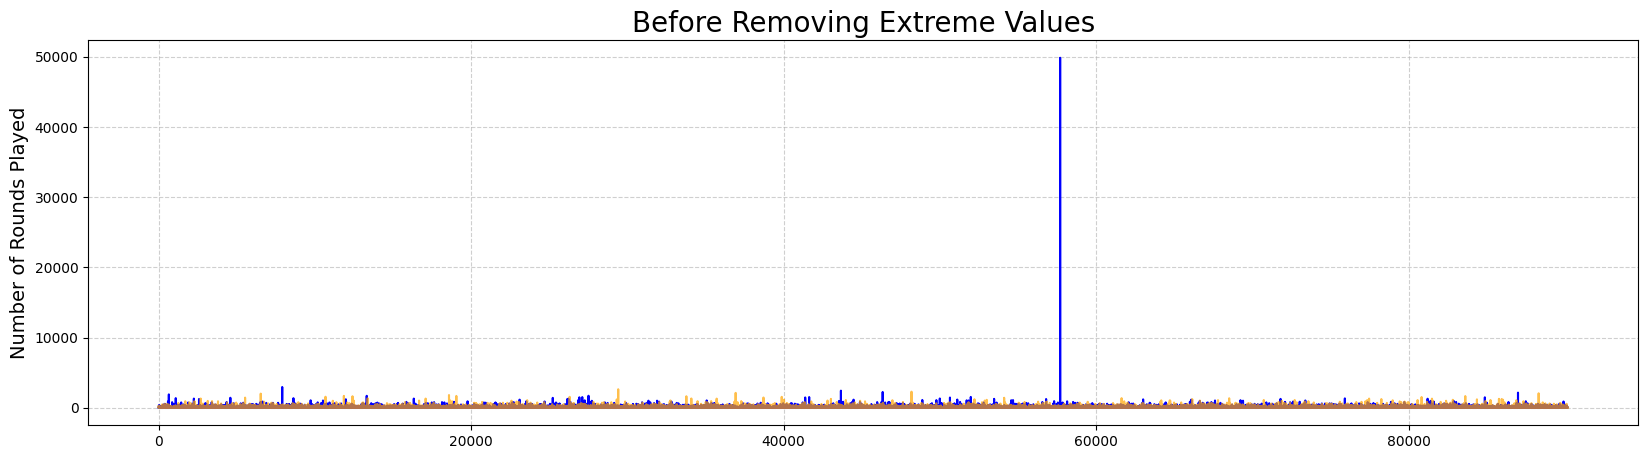

In [8]:
fig,ax = plt.subplots(figsize=(20,5))

ax.plot(df[df['version'] == 'gate_30'].index,
        df[df['version'] == 'gate_30']['sum_gamerounds'],
        label = "Gate 30 (A)",
        color='blue')

ax.plot(df[df['version'] == 'gate_40'].index,
        df[df['version'] == 'gate_40']['sum_gamerounds'],
        label = "Gate 40 (A)",
        color='orange',alpha=0.7)

ax.set_title("Before Removing Extreme Values", fontsize=20)
ax.set_ylabel("Number of Rounds Played", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)

# **3. Outlier Treatments**

In [9]:
#Removing the outlier from the dataset
max_value = df['sum_gamerounds'].max()
df = df[df['sum_gamerounds'] < max_value]

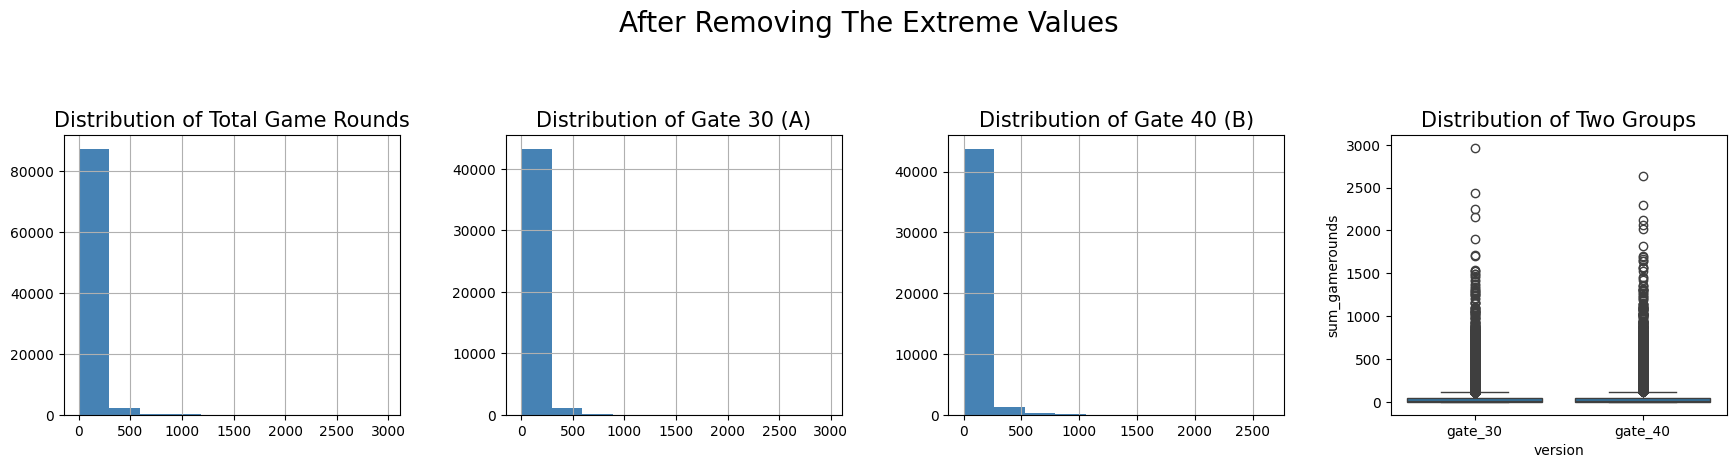

In [10]:
#Plotting after outliet treatment

fig,ax = plt.subplots(1,4,figsize=(18,5))

df['sum_gamerounds'].hist(ax=ax[0],color = "steelblue")
df[df['version'] == 'gate_30'].hist("sum_gamerounds",ax=ax[1],color = "steelblue")
df[df['version'] == 'gate_40'].hist("sum_gamerounds",ax=ax[2],color = "steelblue")
sns.boxplot(x=df['version'],y=df['sum_gamerounds'],ax=ax[3])

plt.suptitle("After Removing The Extreme Values", fontsize = 20)

ax[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
ax[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
ax[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
ax[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 3);


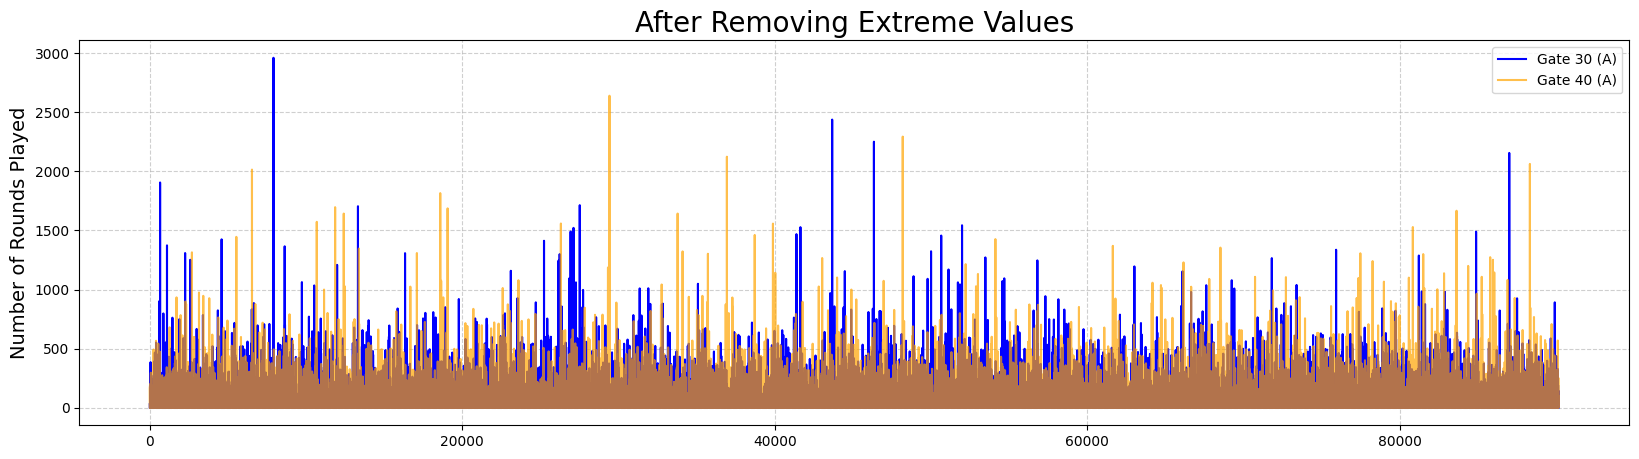

In [11]:
fig,ax = plt.subplots(figsize=(20,5))

ax.plot(df[df['version'] == 'gate_30'].index,
        df[df['version'] == 'gate_30']['sum_gamerounds'],
        label = "Gate 30 (A)",
        color='blue')

ax.plot(df[df['version'] == 'gate_40'].index,
        df[df['version'] == 'gate_40']['sum_gamerounds'],
        label = "Gate 40 (A)",
        color='orange',alpha=0.7)

ax.set_title("After Removing Extreme Values", fontsize=20)
ax.set_ylabel("Number of Rounds Played", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()

In [12]:
# Number of users who did not play the game at all
df[df['sum_gamerounds'] == 0]['userid'].count()

3994


**The users installed the game but 3994 users never played the game!** situation.
Below reasons may explain this situation.

- They have no free time to play game
- Users might prefer to play other games or they play other games already
- Some users don't like the app etc.
- You can comment below for this users also

**The number of users decreases as the levels progress**

- Most of users played the game at early stage and they didn't progress.
- Tactile Entertainment should learn why users churn playing the game.
- Doing research and collecting data about the game and users would help to understand user churn
- The difficulty of the game can be measured
- Gifts might help player retention

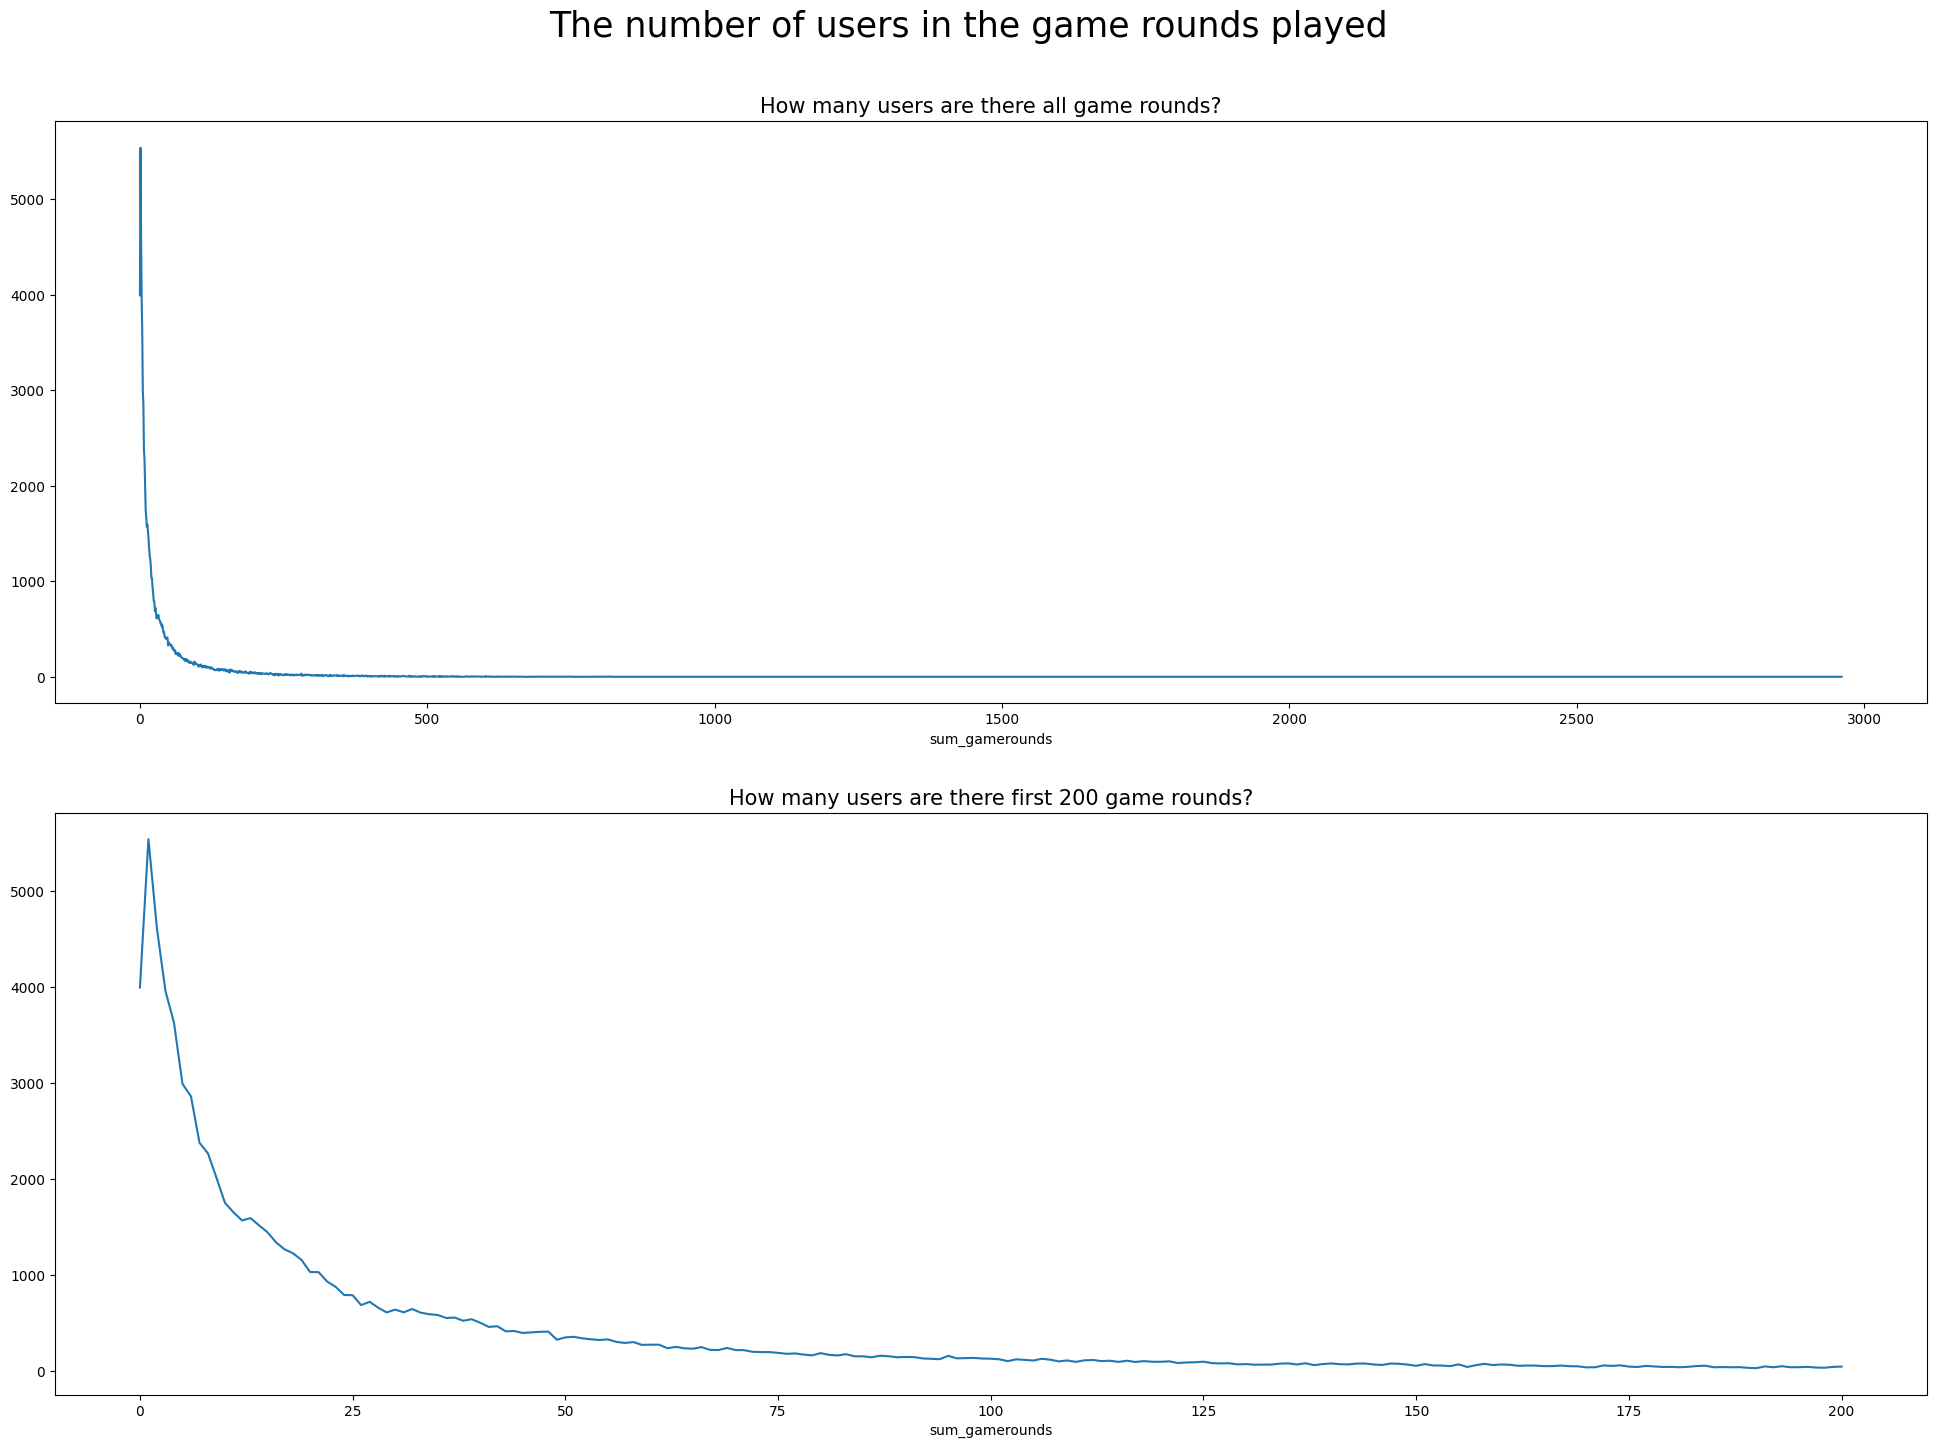

In [13]:
fig,ax = plt.subplots(2,1,figsize=(20,15))
df.groupby('sum_gamerounds')['userid'].count().plot(ax=ax[0])
df.groupby('sum_gamerounds')['userid'].count()[:201].plot(ax=ax[1])

plt.suptitle("The number of users in the game rounds played", fontsize = 25)
ax[0].set_title("How many users are there all game rounds?", fontsize = 15)
ax[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=3);

In [14]:
#Number of uses who reached gate 30 & gate 40 levels in the game
df.groupby('sum_gamerounds')['userid'].count().loc[[30,40]].reset_index()

,sum_gamerounds,userid
0,30,642
1,40,505


In [15]:
#Retention of players after game round 1 and gane round 7
pd.DataFrame(
       {
        'RET1_COUNT': df['retention_1'].value_counts(),
        'RET7_COUNT': df['retention_7'].value_counts(),
        'RET1_PCT': df['retention_1'].value_counts(normalize=True)*100,
        'RET7_PCT': df['retention_7'].value_counts(normalize=True)*100
        }
    )

,RET1_COUNT,RET7_COUNT,RET1_PCT,RET7_PCT
False,50035,73408,55.4786,81.3944
True,40153,16780,44.5214,18.6056


**Retention variables gives us player retention details.**

<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>

Also players tend not to play the game! There are many players who quit the game.

- 55 percent of the players didn't play the game 1 day after installing
- 81 percent of the players didn't play the game 7 day after installing

In [16]:
#Checking the retention of Players for Gate30 & Gate40 version
df.groupby(['version','retention_1'])['sum_gamerounds'].agg(['min','count','median','mean','std','max'])

min  count  median    mean      std   max
version retention_1                                           
gate_30 False          0  24665  6.0000 16.3591  36.5284  1072
        True           0  20034 48.0000 94.4117 135.0377  2961
gate_40 False          0  25370  6.0000 16.3404  35.9258  1241
        True           0  20119 49.0000 95.3812 137.8873  2640

Summary Stats for retention_1 based on Gate 30 & Gate 40 version.  
Gate 30 (A) - **20034** returned after day 1 out of **44699** which is **44.83%**    
Gate 40 (B) - **20119** returned after day 1 out of **45849** which is **43.89%**

In [17]:
#Checking the retention of Players for Gate30 & Gate40 version
df.groupby(['version','retention_7'])['sum_gamerounds'].agg(['min','count','median','mean','std','max'])

min  count   median     mean      std   max
version retention_7                                             
gate_30 False          0  36198  11.0000  25.7965  43.3162   981
        True           0   8501 105.0000 160.1175 179.3586  2961
gate_40 False          0  37210  11.0000  25.8564  44.4061  2640
        True           0   8279 111.0000 165.6498 183.7925  2294

Summary Stats for retention_7 based on Gate 30 & Gate 40 version.  
Gate 30 (A) - **8501** returned after day 7 out of **44699** which is **19.01%**    
Gate 40 (B) - **8279** returned after day 7 out of **45849** which is **18.2%**

In [24]:
#Combining the retentions(player who came back after day 1 and day 7) and checking for the better version
df['Retention'] = np.where((df['retention_1'] == True) & (df['retention_7'] == True),1,0)
df.groupby(['version','Retention'])['sum_gamerounds'].agg(['min','count','median','mean','std','max'])

min  count   median     mean      std   max
version Retention                                             
gate_30 0            0  38023  12.0000  28.0703  48.0175  1072
        1            0   6676 127.0000 183.8863 189.6264  2961
gate_40 0            0  38983  12.0000  28.1034  48.9278  2640
        1            0   6506 133.0000 190.2824 194.2201  2294

Summary Stats for both retention_1 & retention_7 based on Gate 30 & Gate 40 version.  
Gate 30 (A) - **6676** returned after day 1 & day 7 out of **44699** which is **14.93%**    
Gate 40 (B) - **6506** returned after day 1 & day 7  out of **45849** which is **14.19%**


We need to check if the above numbers are statistically significant.

# **4. A/B Testing**

**Assumptions:**
*   Check normality
*   If Normally Distributed, check homogeneity


**Steps:**

1.   Split & Define Control Group & Test Group
2.   Apply Shapiro Test for normality
3.   If parametric apply Levene Test for homogeneity of variances
4.   If Parametric + homogeneity of variances apply T-Test
5.   If Parametric - non-homogeneity of variances apply Welch Test
6.   If Non-parametric apply Mann Whitney U Test directly







In [27]:
#Define A/B groups
df['version(A/B)'] = np.where(df['version'] == 'gate_30','A','B')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,version(A/B)
0,116,gate_30,3,False,False,0,A
1,337,gate_30,38,True,False,0,A
2,377,gate_40,165,True,False,0,B
3,483,gate_40,1,False,False,0,B
4,488,gate_40,179,True,True,1,B


In [36]:
# A/B testing function
def AB_test(dataframe,group,target,alpha=0.05):

    # Split A/B
    groupA = dataframe[dataframe[group] == 'A'][target]
    groupB = dataframe[dataframe[group] == 'B'][target]

    # Assumption: Normality (Shapiro-Wilk test)
    p_value_A = shapiro(groupA)[1] # p-value for group A normality test
    p_value_B = shapiro(groupB)[1] # p-value for group B normality test

    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    # If both groups are normally distributed
    if p_value_A > alpha and p_value_B > alpha: # H0: Distribution is Normal!
        # Parametric Test
        # Assumption: Homogeneity of variances
        levene_test = stats.levene(groupA,groupB)[1] < alpha
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        if levene_test == False:
        # Homogeneity
            test_stat, p_value = stats.ttest_ind(groupA,groupB,equal_var=True)
            test_type = "Parametric (Homogeneous)"
        else:
        # Heterogeneous
            test_stat, p_value = stats.ttest_ind(groupA, groupB, equal_var=False)
            test_type = "Parametric (Heterogeneous)"
    else:
        # Non-Parametric Test
        test_stat, p_value = stats.mannwhitneyu(groupA, groupB)
        test_type = "Non-Parametric"

    #Result
    result = pd.DataFrame(
        {
            "Test Statistic": [test_stat],
            "p-value": [p_value],
            "Test Type": [test_type],
            "Reject H0": [p_value < alpha],
            "Comment": ["Reject H0: A/B groups are not similar!" if p_value < alpha else "Fail to reject H0: A/B groups are similar!"]
        }
    )

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return result


# Apply A/B Testing
AB_test(dataframe=df, group = "version(A/B)", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Statistic,p-value,Test Type,Reject H0,Comment
0,1024285761.5000,0.0509,Non-Parametric,False,Fail to reject H0: A/B groups are similar!


# **5. Conclusion**

**Business Problem Context:**
In this project, we analyzed the impact of changing the first gate in the game Cookie Cats from level 30 to level 40, focusing on player retention and game rounds.

**Data and Pre-Test Observations:**
Before running the A/B test, we examined the data for any missing values or outliers. There were no missing values, but we did identify one outlier in the data. Summary statistics and plots helped us better understand the relationships in the data.

**A/B Testing:**
We performed an A/B test using the **Mann-Whitney U test** (since the data didn’t meet the normality assumption). The test yielded a **p-value of 0.0509**, which is just above our significance threshold of 0.05, meaning **we fail to reject the null hypothesis**. This suggests that there is **no statistically significant difference between the two groups** in terms of game rounds played. Hence, we conclude that A/B groups are similar in this regard.

**Retention Analysis:**
When analyzing player retention (1-day and 7-day retention), we found that retention was higher at level 30 (Gate 30) than at level 40 (Gate 40). **Specifically, the 1-day and 7-day average retention rates were higher for players at Gate 30, indicating that level 30 may be more favorable in terms of keeping players engaged.**